In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(cowplot))

## For loading Arial font for publication
# library(extrafont)

# font_import(pattern = "Arial", prompt = FALSE)
# loadfonts(device = "pdf")

In [2]:
# Output
out_pdf <- "results/primary/dx_yield.diseaseCat.pdf"

# Extract the directory path from the full file path
out_dir <- dirname(out_pdf)

# Create the directory if it doesn't exist
if (!dir.exists(out_dir)) {
  dir.create(out_dir, recursive = TRUE)
}

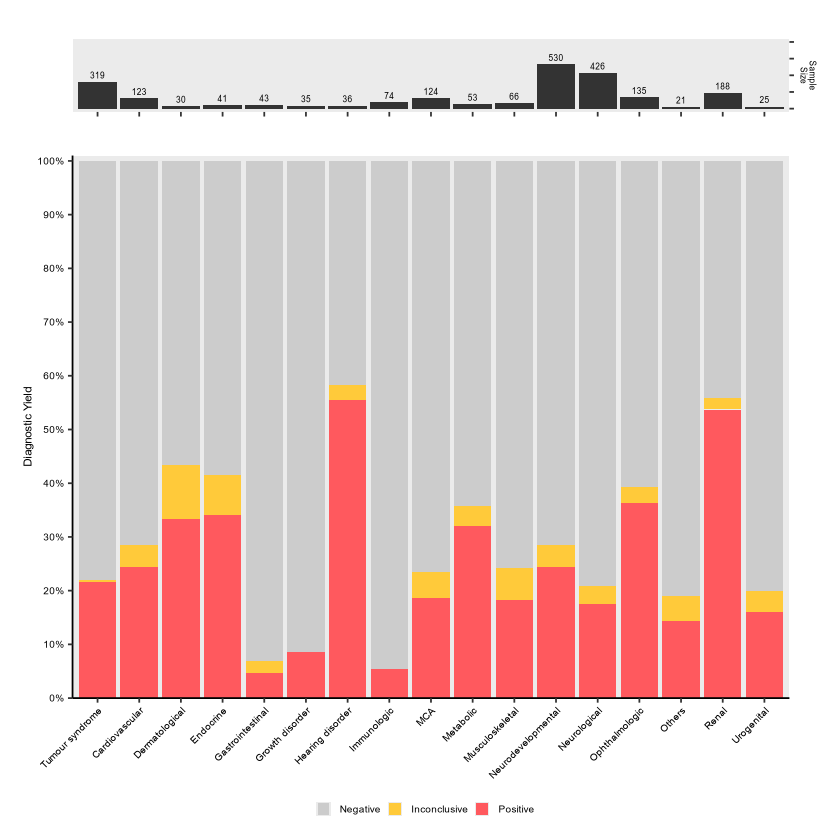

In [3]:
dx_cat_tsv <- "resources/dx_yield_byDiseases.tsv"
dx_cat <- read.table(dx_cat_tsv, sep = "\t", header = TRUE)

# Reorder disease categories: "Tumour syndrome" first, then the rest (alphabetically)
ordered_diseases <- c("Tumour syndrome", sort(setdiff(unique(dx_cat$Diseases), "Tumour syndrome")))
dx_cat$Diseases <- factor(dx_cat$Diseases, levels = ordered_diseases)

# Calculate the proportion of positive/inconclusive/negative results
dx_cat$Positive_prop <- dx_cat$Positive / dx_cat$Total
dx_cat$Negative_prop <- dx_cat$Negative / dx_cat$Total
dx_cat$Inconclusive_prop <- dx_cat$Inconclusive / dx_cat$Total

# Normalize the data for stacked bar chart
dx_cat_long <- dx_cat %>%
  select(Diseases, Negative_prop, Inconclusive_prop, Positive_prop, Total) %>%
  pivot_longer(cols = c(Negative_prop, Inconclusive_prop, Positive_prop),
               names_to = "Result",
               values_to = "Proportion")

# Ensure dx_cat_long uses the same order for Diseases
dx_cat_long$Diseases <- factor(dx_cat_long$Diseases, levels = ordered_diseases)

# Customize the order of fractions (stacked segments)
dx_cat_long$Result <- factor(dx_cat_long$Result, levels = c("Negative_prop", "Inconclusive_prop", "Positive_prop"))

# Create a new dataset for the Total sample size
dx_cat_total <- dx_cat %>%
  select(Diseases, Total) %>%
  mutate(Result = "Total", Proportion = Total / max(Total))  # Normalize Total for consistent scaling

# (Optional) Make sure dx_cat_total$Diseases is a factor with the same levels
dx_cat_total$Diseases <- factor(dx_cat_total$Diseases, levels = ordered_diseases)

# Combine the datasets
combined_data <- bind_rows(
  dx_cat_total %>% mutate(Chart = "Total Sample Size"),
  dx_cat_long %>% mutate(Chart = "Proportion")
)

# Define custom colors for each proportion
custom_colors <- c(
  "Positive_prop" = "#ff595e",      # Green for Positive
  "Inconclusive_prop" = "#ffca3a",   # Yellow for Inconclusive
  "Negative_prop" = "#cccccc"        # Grey for Negative (renamed from red in the comment)
)

# Plot a bar chart with Diseases and Total
p1 <- ggplot(dx_cat, aes(x = Diseases, y = Total)) +
  geom_col(fill = "#333333", width = .92) +  # Bar chart with dark bars
  geom_text(aes(label = Total), 
            vjust = -0.5, 
            # family = "Arial", 
            size = 5/ggplot2::.pt
           ) +  # Add data labels above bars
  labs(
    x = "Disease Categories",
    y = "Sample\nSize"
  ) +
  scale_y_continuous(
    position = "right", 
    limits = c(0, max(dx_cat$Total)*1.5), 
    guide = guide_axis(angle = 0)
  ) + 
  # theme_minimal(base_family = "Arial") +
  theme(
    axis.text.x = element_blank(),
    axis.text.y = element_blank(),
    axis.title.x = element_blank(),
    axis.title.y = element_text(size = 5),
    plot.title = element_blank(),
    plot.margin = unit(c(0, 0.5, 0, 0.5), "cm"), 
    panel.grid = element_blank()
  ) +
  coord_fixed(ratio = 0.002)  # Adjust the aspect ratio


# Plot the stacked normalized bar chart
p2 <- ggplot(dx_cat_long, aes(x = Diseases, y = Proportion, fill = Result)) +
  geom_bar(stat = "identity", position = "fill") + 
  scale_y_continuous(
    labels = scales::percent_format(), 
    breaks = seq(0, 1.01, by = 0.1),
    limits = c(0, 1.01), 
    expand = c(0, 0)
  ) + 
  scale_fill_manual(values = custom_colors, labels = c("Negative", "Inconclusive", "Positive")) +
  labs(
    x = "",
    y = "Diagnostic Yield",
    fill = ""
  ) +
  # theme_minimal(base_family = "Arial") +
  theme(
    axis.text.x = element_text(angle = 45, size = 6, color = 'black', hjust = 1),
    axis.text.y = element_text(size = 6, color = 'black'), 
    axis.title.x = element_blank(),
    axis.title.y = element_text(size = 7, color = 'black'),
    plot.title = element_blank(),
    plot.margin = unit(c(0, 0.5, 0, 0.5), "cm"), 
    panel.grid = element_blank(), 
    axis.line = element_line(), 
    legend.title = element_text(size = 7),
    legend.text = element_text(size = 6),
    legend.key.size = unit(0.3, "cm"),
    legend.position = "bottom",
    legend.direction = "horizontal"
  )


# Show individual plots on screen
# print(p1)
# print(p2)

# Extract the legend from p2
legend <- get_legend(p2)
# Create a version of p2 without the legend
p2_nolegend <- p2 + theme(legend.position = "none")

# Combine the plots using cowplot instead of patchwork
combined_plot <- plot_grid(
  p1, p2_nolegend, legend,
  ncol = 1,
  rel_heights = c(0.25, 1, 0.1),
  align = 'v',
  axis = 'lr'
)

print(combined_plot)

# Export the plot to PDF    
ggsave(
  filename = out_pdf, 
  plot = combined_plot, 
  width = 110, height = 74, 
  units = "mm", dpi = 600
)